<a id='top'></a>

# TransferMarkt Player Bio and Status Data Engineering
##### Notebook to engineer data scraped from [TransferMarkt](https://www.transfermarkt.co.uk/) using the [Tyrone Mings web scraper](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://twitter.com/FC_rstats).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 13/09/2020<br>
Notebook last updated: 30/08/2021

![title](../../img/transfermarkt-logo-banner.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers previously scraped data from [TransferMarkt](https://www.transfermarkt.co.uk/) using the [FCrSTATS](https://twitter.com/FC_rstats) [Tyrone Mings webscraper](https://github.com/FCrSTATS/tyrone_mings)  and manipulates this landed data as DataFrames using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [72]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Flatten lists
from functools import reduce

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Currency Converter
from currency_converter import CurrencyConverter

# APIs
from tyrone_mings import * 

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2
Seaborn: 0.11.2


### Defined Filepaths

In [73]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Lists

In [61]:
# Defined Lists

## Define list of league codes
df_leagues = pd.read_csv(data_dir_tm + '/reference/tm_leagues_comps.csv')
lst_league_codes = df_leagues['league_code'].to_numpy().tolist()

## Define list of 'Big 5' European Leagues and MLS codes
lst_big5_mls_league_codes = ['GB1', 'FR1', 'L1', 'IT1', 'ES1', 'MLS1']

### Notebook Settings

In [5]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and the model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several data eningeering notebooks, that cleans player bio and status (valuation) data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/).

[TransferMarkt](https://www.transfermarkt.co.uk/) is a German-based website owned by [Axel Springer](https://www.axelspringer.com/en/) and is the leading website for the football transfer market. The website posts football related data, including: scores and results, football news, transfer rumours, and most usefully for us - calculated estimates ofthe market values for teams and individual players.

To read more about how these estimations are made, [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann does an excellent job of explaining how the estimations are made and their level of accuracy.

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Valuation Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Valuation%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Valuation Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Valuation%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Bio and Status Dataset</a>

#### <a id='#section3.2.1'>3.2.1. Data Dictionaries</a>
The [TransferMarkt](https://www.transfermarkt.co.uk/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

#### <a id='#section3.2.2'>3.2.2. Import CSV files as pandas DataFrames</a>

##### Import Bio data

In [9]:
# Import DataFrame as a CSV file
df_tm_bio_raw = pd.read_csv(data_dir_tm + f'/raw/bio/tm_player_bio_combined_latest.csv')

##### Import Status data

In [10]:
# Import DataFrame as a CSV file
df_tm_status_raw = pd.read_csv(data_dir_tm + f'/raw/status/tm_player_status_combined_latest.csv')

#### <a id='#section3.2.3'>3.2.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

##### Bio data

In [11]:
# Display the first five rows of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.head()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,citizenship,second_citizenship,league_code,season
0,2963,martín demichelis,20.0,12.0,1980.0,Justiniano Posse,Argentina,1980-12-20,Defender - Centre-Back,184.0,right,NaN,Italy,ES1,2016
1,5404,jérémy mathieu,29.0,10.0,1983.0,Luxeuil-les-Bains,France,1983-10-29,Defender - Centre-Back,189.0,left,France,NaN,ES1,2016
2,5856,daniele bonera,31.0,5.0,1981.0,Brescia,Italy,1981-05-31,Defender - Centre-Back,183.0,right,Italy,NaN,ES1,2016
3,7593,fernando navarro,25.0,6.0,1982.0,Barcelona,Spain,1982-06-25,Defender - Left-Back,176.0,left,Spain,NaN,ES1,2016
4,7600,andrés iniesta,11.0,5.0,1984.0,Fuentealbilla,Spain,1984-05-11,midfield - Central Midfield,171.0,both,Spain,NaN,ES1,2016


In [12]:
# Display the last five rows of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.tail()

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,citizenship,second_citizenship,league_code,season
24206,898751,mamadou fall,21.0,11.0,2002.0,Rufisque,Senegal,2002-11-21,Defender - Centre-Back,189.0,NaN,Senegal,NaN,MLS1,2020
24207,900440,bryce washington,12.0,9.0,1998.0,"Atlanta, Georgia",United States,1998-09-12,Defender - Centre-Back,188.0,NaN,United States,NaN,MLS1,2020
24208,900569,george asomani,26.0,3.0,1999.0,Accra,Ghana,1999-03-26,midfield - Defensive Midfield,168.0,NaN,Ghana,NaN,MLS1,2020
24209,905609,arquimides ordonez,5.0,8.0,2003.0,"Cincinnati, Ohio",United States,2003-08-05,attack - Centre-Forward,188.0,NaN,NaN,Guatemala,MLS1,2020
24210,921655,ismaël koné,6.0,6.0,2002.0,Abidjan,Cote d'Ivoire,2002-06-06,midfield - Central Midfield,188.0,NaN,NaN,Cote d'Ivoire,MLS1,2020


In [13]:
# Print the shape of the raw DataFrame, df_tm_bio_raw
print(df_tm_bio_raw.shape)

(24211, 15)


In [14]:
# Print the column names of the raw DataFrame, df_tm_bio_raw
print(df_tm_bio_raw.columns)

Index(['player_id', 'player_name', 'day_of_birth', 'month_of_birth',
       'year_of_birth', 'pob', 'cob', 'dob', 'position', 'height', 'foot',
       'citizenship', 'second_citizenship', 'league_code', 'season'],
      dtype='object')


The dataset has thirteen features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Data types of the features of the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.dtypes

player_id               int64
player_name            object
day_of_birth          float64
month_of_birth        float64
year_of_birth         float64
pob                    object
cob                    object
dob                    object
position               object
height                float64
foot                   object
citizenship            object
second_citizenship     object
league_code            object
season                  int64
dtype: object

All thirteen of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [16]:
# Info for the raw DataFrame, df_tm_bio_raw
df_tm_bio_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24211 entries, 0 to 24210
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_id           24211 non-null  int64  
 1   player_name         24211 non-null  object 
 2   day_of_birth        24171 non-null  float64
 3   month_of_birth      24171 non-null  float64
 4   year_of_birth       24171 non-null  float64
 5   pob                 23930 non-null  object 
 6   cob                 24172 non-null  object 
 7   dob                 24171 non-null  object 
 8   position            24172 non-null  object 
 9   height              23802 non-null  float64
 10  foot                22565 non-null  object 
 11  citizenship         15651 non-null  object 
 12  second_citizenship  8521 non-null   object 
 13  league_code         24211 non-null  object 
 14  season              24211 non-null  int64  
dtypes: float64(4), int64(2), object(9)
memory usage: 2.8+

In [17]:
# Description of the raw DataFrame, df_tm_bio_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_bio_raw.describe()

,player_id,day_of_birth,month_of_birth,year_of_birth,height,season
count,24211.000000,24171.000000,24171.000000,24171.000000,23802.000000,24211.000000
mean,249165.466606,15.400811,5.840429,1993.637086,182.295395,2018.368551
std,179097.376690,8.762392,3.438228,4.951668,6.759016,1.637394
min,26.000000,1.000000,1.000000,1975.000000,158.000000,2016.000000
25%,93604.000000,8.000000,3.000000,1990.000000,178.000000,2017.000000
50%,221150.000000,15.000000,5.000000,1994.000000,183.000000,2018.000000
75%,361104.000000,23.000000,9.000000,1997.000000,187.000000,2020.000000
max,921655.000000,31.000000,12.000000,2006.000000,202.000000,2021.000000


<AxesSubplot:>

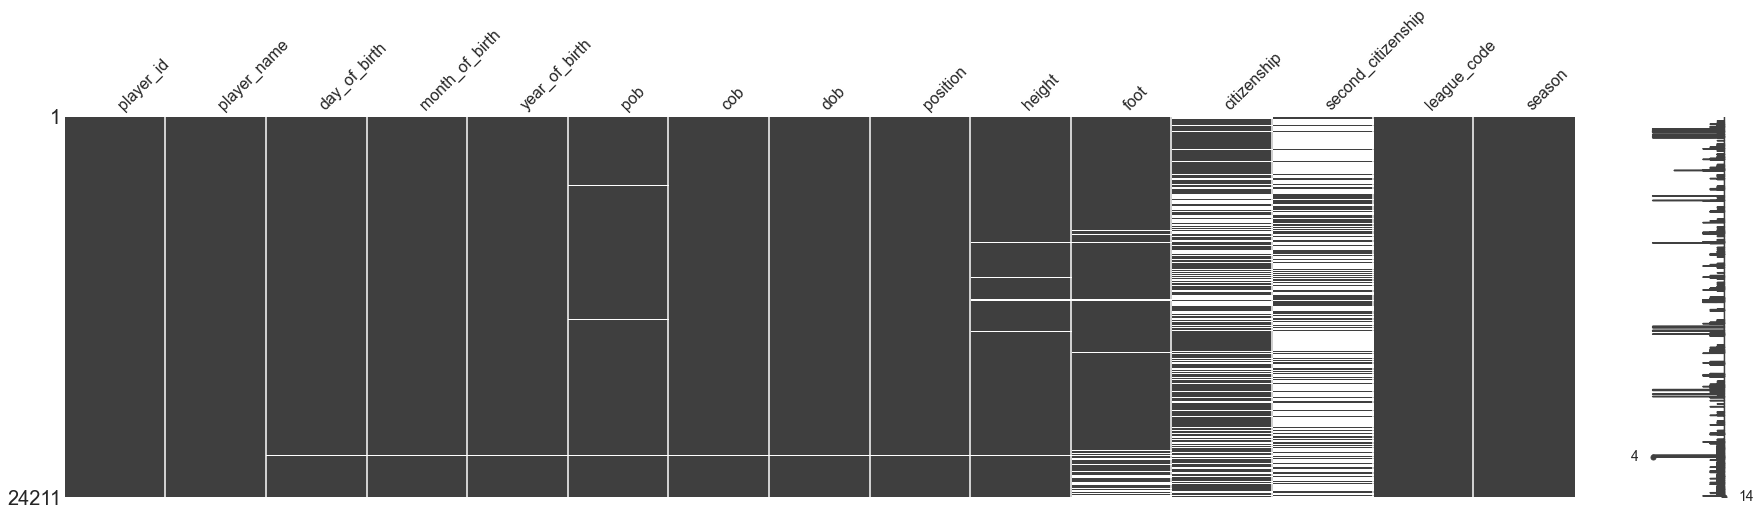

In [18]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_bio_raw
msno.matrix(df_tm_bio_raw, figsize = (30, 7))

In [19]:
# Counts of missing values
tm_bio_null_value_stats = df_tm_bio_raw.isnull().sum(axis=0)
tm_bio_null_value_stats[tm_bio_null_value_stats != 0]

day_of_birth             40
month_of_birth           40
year_of_birth            40
pob                     281
cob                      39
dob                      40
position                 39
height                  409
foot                   1646
citizenship            8560
second_citizenship    15690
dtype: int64

The visualisation shows us very quickly that there a few missing values in most of the columns, but the dataset is ready for us.

##### Status data

In [20]:
# Display the first five rows of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.head()

,player_id,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,league_code,season
0,2963,retired,NaN,0,2017-07-01,NaN,NaN,NaN,NaN,NaN,Jorge Cyterszpiler,ES1,2016
1,5404,retired,NaN,0,2020-07-01,NaN,NaN,NaN,NaN,NaN,Team Spirit Football Consult.,ES1,2016
2,5856,retired,NaN,0,2019-07-01,NaN,NaN,NaN,NaN,NaN,TMP SOCCER srl,ES1,2016
3,7593,retired,NaN,0,2018-07-01,NaN,NaN,NaN,NaN,NaN,AC Talent,ES1,2016
4,7600,vissel kobe,japan,2300000,2018-07-01,2024-01-31,NaN,NaN,NaN,NaN,Sports&Life,ES1,2016


In [21]:
# Display the last five rows of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.tail()

,player_id,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,league_code,season
24327,898751,los angeles fc,united states,50000,2021-06-04,2022-12-31,club option 2 years,NaN,NaN,NaN,NaN,MLS1,2020
24328,900440,atlanta united fc,united states,25000,2021-06-04,2022-12-31,club option 3 years,NaN,NaN,NaN,NaN,MLS1,2020
24329,900569,san jose earthquakes,united states,25000,2021-01-21,2021-12-31,club option 3 years,NaN,NaN,NaN,NaN,MLS1,2020
24330,905609,fc cincinnati,united states,25000,2021-07-02,2023-12-31,club option 2 years,NaN,NaN,NaN,Remington Ellis Management,MLS1,2020
24331,921655,club de foot montréal,canada,0,2021-08-13,2022-12-31,club option 2 years,NaN,NaN,NaN,Axia Sports Management,MLS1,2020


In [22]:
# Print the shape of the raw DataFrame, df_tm_status_raw
print(df_tm_status_raw.shape)

(24332, 13)


In [23]:
# Print the column names of the raw DataFrame, df_tm_status_raw
print(df_tm_status_raw.columns)

Index(['player_id', 'current_club', 'current_club_country', 'market_value',
       'joined', 'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'league_code', 'season'],
      dtype='object')


The dataset has thirteen features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [24]:
# Data types of the features of the raw DataFrame, df_tm_status_raw
df_tm_status_raw.dtypes

player_id                int64
current_club            object
current_club_country    object
market_value             int64
joined                  object
contract_expires        object
contract_option         object
on_loan_from            object
on_loan_from_country    object
loan_contract_expiry    object
player_agent            object
league_code             object
season                   int64
dtype: object

All thirteen of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [25]:
# Info for the raw DataFrame, df_tm_status_raw
df_tm_status_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24332 entries, 0 to 24331
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   player_id             24332 non-null  int64 
 1   current_club          24332 non-null  object
 2   current_club_country  21817 non-null  object
 3   market_value          24332 non-null  int64 
 4   joined                24324 non-null  object
 5   contract_expires      19675 non-null  object
 6   contract_option       2085 non-null   object
 7   on_loan_from          1851 non-null   object
 8   on_loan_from_country  1851 non-null   object
 9   loan_contract_expiry  1570 non-null   object
 10  player_agent          20805 non-null  object
 11  league_code           24332 non-null  object
 12  season                24332 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 2.4+ MB


In [26]:
# Description of the raw DataFrame, df_tm_status_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_status_raw.describe()

,player_id,market_value,season
count,24332.000000,2.433200e+04,24332.000000
mean,248287.445792,6.062581e+06,2018.352992
std,178109.795844,1.235660e+07,1.630859
min,26.000000,0.000000e+00,2016.000000
25%,93704.000000,3.250000e+05,2017.000000
50%,218129.000000,1.500000e+06,2018.000000
75%,358148.500000,5.000000e+06,2020.000000
max,921655.000000,1.600000e+08,2021.000000


<AxesSubplot:>

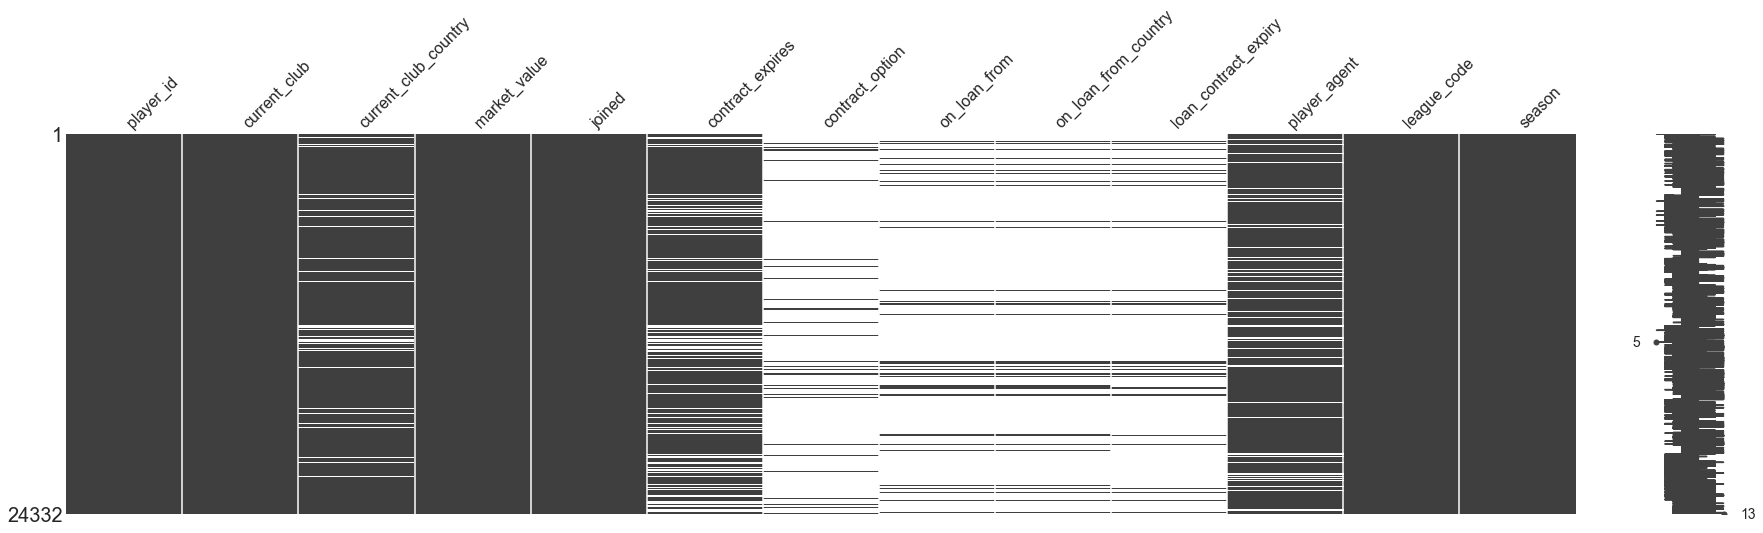

In [27]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_status_raw
msno.matrix(df_tm_status_raw, figsize = (30, 7))

In [28]:
# Counts of missing values
tm_status_null_value_stats = df_tm_status_raw.isnull().sum(axis=0)
tm_status_null_value_stats[tm_status_null_value_stats != 0]

current_club_country     2515
joined                      8
contract_expires         4657
contract_option         22247
on_loan_from            22481
on_loan_from_country    22481
loan_contract_expiry    22762
player_agent             3527
dtype: int64

The visualisation shows us very quickly that there a few missing values in most of the columns, but the dataset is ready for us.

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Bio and Status Datasets</a>

#### <a id='#section4.1.1'>4.1.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [29]:
# Assign Raw DataFrames to new Engineered DataFrames
df_tm_bio = df_tm_bio_raw.copy()
df_tm_status = df_tm_status_raw.copy()

#### <a id='#section4.1.2'>4.1.2. Dedupe DataFrames</a>
A copy of each player is saved per season, causing duplication if not treated.

##### Bio data

In [30]:
df_tm_bio = (df_tm_bio
                 .sort_values(['season', 'player_id'], ascending=[False, True])
                #.drop(columns=['league_code', 'season'])
                 .drop_duplicates(subset=['player_id'], keep='first')
            )

In [31]:
print('No. rows in Bio DataFrame BEFORE deduplication: {}'.format(len(df_tm_bio_raw)))
print('No. rows in DataFrame AFTER deduplication: {}\n'.format(len(df_tm_bio)))
print('Variance in rows before and after deduplication: {}\n'.format(len(df_tm_bio_raw) - len(df_tm_bio)))
print('-'*10)

No. rows in Bio DataFrame BEFORE deduplication: 24211
No. rows in DataFrame AFTER deduplication: 9429

Variance in rows before and after deduplication: 14782

----------


In [32]:
df_tm_bio['player_id'].nunique()

9429

##### Status data

In [33]:
df_tm_status = (df_tm_status
                    .sort_values(['season', 'player_id'], ascending=[False, True])
                    .drop(columns=['league_code', 'season'])
                    .drop_duplicates(subset=['player_id'], keep='first')
               )

In [34]:
print('No. rows in Status DataFrame BEFORE deduplication: {}'.format(len(df_tm_status_raw)))
print('No. rows in DataFrame AFTER deduplication: {}\n'.format(len(df_tm_status)))
print('Variance in rows before and after deduplication: {}\n'.format(len(df_tm_status_raw) - len(df_tm_status)))
print('-'*10)

No. rows in Status DataFrame BEFORE deduplication: 24332
No. rows in DataFrame AFTER deduplication: 9323

Variance in rows before and after deduplication: 15009

----------


In [35]:
df_tm_status['player_id'].nunique()

9323

#### <a id='#section4.1.2'>4.1.2. Join Bio and Status Datasets</a>

In [36]:
# Join the Bio and Status DataFrames to form one, unified DataFrame
df_tm_bio_status = pd.merge(df_tm_bio, df_tm_status, left_on='player_id', right_on='player_id', how='left')

In [37]:
print('No. rows in Bio DataFrame BEFORE join to Status data: {}'.format(len(df_tm_bio)))
print('No. rows in DataFrame AFTER join: {}\n'.format(len(df_tm_bio_status)))
print('Variance in rows before and after join: {}\n'.format(len(df_tm_bio_status) - len(df_tm_bio)))
print('-'*10)

No. rows in Bio DataFrame BEFORE join to Status data: 9429
No. rows in DataFrame AFTER join: 9429

Variance in rows before and after join: 0

----------


In [38]:
df_tm_bio_status.shape

(9429, 25)

#### <a id='#section4.1.3'>4.1.3. String Cleaning</a>

##### Name

In [39]:
# 
df_tm_bio_status['name_lower'] = (df_tm_bio_status['player_name']
                                      .str.normalize('NFKD')
                                      .str.encode('ascii', errors='ignore')
                                      .str.decode('utf-8')
                                      .str.lower()
                                 )

# First Name Lower
df_tm_bio_status['firstname_lower'] = df_tm_bio_status['name_lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_tm_bio_status['lastname_lower'] = df_tm_bio_status['name_lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_tm_bio_status['firstinitial_lower'] = df_tm_bio_status['name_lower'].astype(str).str[0]

##### League Country lower

In [40]:
# Remove accents and create lowercase name
df_tm_bio_status['league_country_lower'] = (df_tm_bio_status['current_club_country']
                                                .str.normalize('NFKD')
                                                .str.encode('ascii', errors='ignore')
                                                .str.decode('utf-8')
                                                .str.lower()
                                           )

#### <a id='#section4.1.4'>4.1.4. Converting Data Types</a>

##### Date Time
First we need to convert the `dob` column from the `object` data type to `datetime64[ns]`, again using the [.to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method.

In [41]:
# Convert birth_date from string to datetime64[ns]
df_tm_bio_status['dob'] = pd.to_datetime(df_tm_bio_status['dob'])
df_tm_bio_status['joined'] = pd.to_datetime(df_tm_bio_status['joined'])
df_tm_bio_status['contract_expires'] = pd.to_datetime(df_tm_bio_status['contract_expires'])

##### Numeric
The `value` column needs to be converted from a string to an integer using to [to_numeric()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html) method.

In [42]:
# Convert string to integer
df_tm_bio_status['market_value'] = pd.to_numeric(df_tm_bio_status['market_value'])

#### <a id='#section4.1.5'>4.1.5. Create New Attributes</a>

##### Position Codes

In [43]:
df_tm_bio_status['position'].unique()

array(['Goalkeeper', 'midfield - Central Midfield',
       'attack - Centre-Forward', 'midfield - Defensive Midfield',
       'attack - Right Winger', 'attack - Second Striker',
       'Defender - Left-Back', 'Defender - Centre-Back',
       'Defender - Right-Back', 'midfield - Attacking Midfield',
       'midfield - Right Midfield', 'attack - Left Winger',
       'midfield - Left Midfield', nan, 'midfield', 'attack', 'Defender'],
      dtype=object)

In [44]:
dict_positions_codes = {'Goalkeeper': 'GK',
                        'Defender': 'DEF',
                        'Defender - Centre-Back': 'CB',
                        'Defender - Left-Back': 'LB',
                        'Defender - Right-Back': 'RB',
                        'midfield': 'MF',
                        'midfield - Central Midfield': 'CM',
                        'midfield - Defensive Midfield': 'CDM',
                        'midfield - Left Midfield': 'LM',
                        'midfield - Right Midfield': 'RM',
                        'midfield - Attacking Midfield': 'CAM',
                        'attack': 'FW',
                        'attack - Left Winger': 'LW',
                        'attack - Right Winger': 'RW',
                        'attack - Second Striker': 'SS',
                        'attack - Centre-Forward': 'ST'
                       }

In [45]:
# Map grouped positions to DataFrame
df_tm_bio_status['position_code'] = df_tm_bio_status['position'].map(dict_positions_codes)

##### Position Grouped

In [46]:
dict_positions_grouped = {'Goalkeeper': 'Goalkeeper',
                          'Defender': 'Defender',
                          'Defender - Centre-Back': 'Defender',
                          'Defender - Left-Back': 'Defender',
                          'Defender - Right-Back': 'Defender',
                          'midfield': 'Midfielder',
                          'midfield - Central Midfield': 'Midfielder',
                          'midfield - Defensive Midfield': 'Midfielder',
                          'midfield - Left Midfield': 'Midfielder',
                          'midfield - Right Midfield': 'Midfielder',
                          'midfield - Attacking Midfield': 'Midfielder',
                          'attack': 'Forward',
                          'attack - Left Winger': 'Forward',
                          'attack - Right Winger': 'Forward',
                          'attack - Second Striker': 'Forward',
                          'attack - Centre-Forward': 'Forward'
                         }

In [47]:
# Map grouped positions to DataFrame
df_tm_bio_status['position_grouped'] = df_tm_bio_status['position'].map(dict_positions_grouped)

##### Goalkeeper / Outfielder

In [48]:
# Separate Goalkeeper and Outfielders
df_tm_bio_status['outfielder_goalkeeper'] = np.where(df_tm_bio_status['position'].isnull(), np.nan, (np.where(df_tm_bio_status['position'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')))                                                 

##### Current Age

In [49]:
now = pd.Timestamp('now')
df_tm_bio_status['dob'] = pd.to_datetime(df_tm_bio_status['dob'], format='%m%d%y')
df_tm_bio_status['dob'] = df_tm_bio_status['dob'].where(df_tm_bio_status['dob'] < now, df_tm_bio_status['dob'] -  np.timedelta64(100, 'Y'))
df_tm_bio_status['age'] = (now - df_tm_bio_status['dob']).astype('<m8[Y]')
df_tm_bio_status['age'] = df_tm_bio_status['age'].astype(np.int64, errors='ignore')

##### Age When Joining Club

In [50]:
from datetime import datetime, timedelta

In [51]:
df_tm_bio_status['age_when_joining'] = (df_tm_bio_status['joined'] - df_tm_bio_status['dob']) / timedelta(days=365)
df_tm_bio_status['age_when_joining'] = np.floor(df_tm_bio_status['age_when_joining'])      

##### Time Since Joining Club

In [52]:
now = pd.Timestamp('now')
df_tm_bio_status['joined'] = pd.to_datetime(df_tm_bio_status['joined'], format='%m%d%y')
df_tm_bio_status['joined'] = df_tm_bio_status['joined'].where(df_tm_bio_status['joined'] < now, df_tm_bio_status['joined'] -  np.timedelta64(100, 'Y'))
df_tm_bio_status['years_since_joining'] = (now - df_tm_bio_status['joined']).astype('<m8[Y]')
df_tm_bio_status['years_since_joining'] = df_tm_bio_status['years_since_joining'].astype(np.int64, errors='ignore')

##### Time Until Contract Expiry

In [53]:
now = pd.Timestamp('now')
df_tm_bio_status['contract_expires'] = pd.to_datetime(df_tm_bio_status['contract_expires'], format='%m%d%y')
#df_tm_bio_status['contract_expires'] = df_tm_bio_status['contract_expires'].where(df_tm_bio_status['contract_expires'] < now, df_tm_bio_status['contract_expires'] - np.timedelta64(100, 'Y'))
df_tm_bio_status['years_until_contract_expiry'] = (df_tm_bio_status['contract_expires'] - now).astype('<m8[Y]')
df_tm_bio_status['years_until_contract_expiry'] = df_tm_bio_status['years_until_contract_expiry'].astype(np.int64, errors='ignore')

In [54]:
df_tm_bio_status.head(50)

,player_id,player_name,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,position,height,foot,citizenship,second_citizenship,league_code,season,current_club,current_club_country,market_value,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry
0,2857,eldin jakupovic,2.0,10.0,1984.0,Kozarac,Jugoslawien (SFR),1984-10-02,Goalkeeper,191.0,right,NaN,Bosnia-Herzegovina,GB1,2021,leicester city,england,300000.0,2017-07-19,2021-06-30,NaN,NaN,NaN,NaN,HSD,eldin jakupovic,eldin,jakupovic,e,england,GK,Goalkeeper,Goalkeeper,36.0,32.0,4.0,-1.0
1,3333,james milner,4.0,1.0,1986.0,Leeds,England,1986-01-04,midfield - Central Midfield,175.0,right,England,NaN,GB1,2021,liverpool fc,england,3000000.0,2015-07-01,2022-06-30,NaN,NaN,NaN,NaN,Samii Sport-Marketing Agentur,james milner,james,milner,j,england,CM,Midfielder,Outfielder,35.0,29.0,6.0,0.0
2,3455,zlatan ibrahimovic,3.0,10.0,1981.0,Malmö,Sweden,1981-10-03,attack - Centre-Forward,195.0,both,NaN,Bosnia-Herzegovina,IT1,2021,ac milan,italy,4000000.0,2020-01-02,2022-06-30,NaN,NaN,NaN,NaN,Mino Raiola,zlatan ibrahimovic,zlatan,ibrahimovic,z,italy,ST,Forward,Outfielder,39.0,38.0,1.0,0.0
3,5578,nicolas penneteau,28.0,2.0,1981.0,Marseille,France,1981-02-28,Goalkeeper,185.0,left,France,NaN,FR1,2021,stade reims,france,200000.0,2021-07-01,2023-06-30,NaN,NaN,NaN,NaN,USM GROUP,nicolas penneteau,nicolas,penneteau,n,france,GK,Goalkeeper,Goalkeeper,40.0,40.0,0.0,1.0
4,6442,antonio rosati,26.0,6.0,1983.0,Tivoli,Italy,1983-06-26,Goalkeeper,195.0,right,Italy,NaN,IT1,2021,acf fiorentina,italy,100000.0,2021-02-01,NaT,NaN,NaN,NaN,NaN,Alessandro Lucci - WSA,antonio rosati,antonio,rosati,a,italy,GK,Goalkeeper,Goalkeeper,38.0,37.0,0.0,NaN
5,7093,francesco magnanelli,12.0,11.0,1984.0,Umbertide,Italy,1984-11-12,midfield - Defensive Midfield,181.0,right,Italy,NaN,IT1,2021,us sassuolo,italy,400000.0,2005-07-01,2022-06-30,NaN,NaN,NaN,NaN,TMP SOCCER srl,francesco magnanelli,francesco,magnanelli,f,italy,CDM,Midfielder,Outfielder,36.0,20.0,16.0,0.0
6,7161,jonas hofmann,14.0,7.0,1992.0,Heidelberg,Germany,1992-07-14,attack - Right Winger,176.0,right,Germany,NaN,L1,2021,borussia mönchengladbach,germany,16000000.0,2016-01-01,2023-06-30,NaN,NaN,NaN,NaN,Dr. Gutfleisch,jonas hofmann,jonas,hofmann,j,germany,RW,Forward,Outfielder,29.0,23.0,5.0,1.0
7,7663,joaquín,21.0,7.0,1981.0,El Puerto de Santa María,Spain,1981-07-21,attack - Right Winger,181.0,right,Spain,NaN,ES1,2021,real betis balompié,spain,1500000.0,2015-08-31,2022-06-30,NaN,NaN,NaN,NaN,Juzzt Football,joaquin,joaquin,joaquin,j,spain,RW,Forward,Outfielder,40.0,34.0,6.0,0.0
8,7825,pepe reina,31.0,8.0,1982.0,Madrid,Spain,1982-08-31,Goalkeeper,188.0,right,Spain,NaN,IT1,2021,ss lazio,italy,800000.0,2020-09-01,2022-06-30,NaN,NaN,NaN,NaN,Manuel García Quilón,pepe reina,pepe,reina,p,italy,GK,Goalkeeper,Goalkeeper,39.0,38.0,0.0,0.0
9,8176,oier olazábal,14.0,9.0,1989.0,Irún,Spain,1989-09-14,Goalkeeper,189.0,left,Spain,NaN,ES1,2021,rcd espanyol barcelona,spain,300000.0,2020-01-31,2022-06-30,NaN,NaN,NaN,NaN,Sport Agency 4U,oier olazabal,oier,olazabal,o,spain,GK,Goalkeeper,Goalkeeper,31.0,30.0,1.0,0.0


#### <a id='#section4.1.6'>4.1.6. Convert Euros to Pounds</a>

In [56]:
# Get EUR to GBP exchange rate

## Get latest currency rates
c = CurrencyConverter()

##  Get conversion rate from EUR to GBP
rate_eur_gbp = (c.convert(1, 'EUR', 'GBP'))
rate_eur_gbp

0.90053

In [57]:
# Overwrite
rate_eur_gbp = 0.90
rate_eur_gbp

0.9

In [58]:
# Convert TM.com Euro value to Pounds
df_tm_bio_status['market_value_gbp'] = df_tm_bio_status['market_value'] * rate_eur_gbp

#### <a id='#section4.1.7'>4.1.7. Rename Columns</a>

In [59]:
df_tm_bio_status = df_tm_bio_status.rename(columns={'player_id': 'tm_id',
                                                    'season_x': 'season',
                                                    'market_value': 'market_value_eur',
                                                    'day_of_birth': 'birth_day',
                                                    'month_of_birth': 'birth_month',
                                                    'year_of_birth': 'birth_year'
                                                   }
                                          )

#### <a id='#section4.1.8'>4.1.8. Filter Players in 'Big 5' European Leagues</a>

In [62]:
# Filter players in the 'Big 5' European Leagues and MLS
df_tm_bio_status_big5_mls = df_tm_bio_status[df_tm_bio_status['league_code'].isin(lst_big5_mls_league_codes)]

In [64]:
print('No. rows in DataFrame BEFORE filtration: {}'.format(len(df_tm_bio_status)))
print('No. rows in DataFrame AFTER filtration: {}\n'.format(len(df_tm_bio_status_big5_mls)))
print('Variance in rows before and after filtration: {}\n'.format(len(df_tm_bio_status_big5_mls) - len(df_tm_bio_status)))
print('-'*10)

No. rows in DataFrame BEFORE filtration: 9429
No. rows in DataFrame AFTER filtration: 9429

Variance in rows before and after filtration: 0

----------


#### <a id='#section4.1.9'>4.1.9. Exporting the Engineered DataFrames</a>
Export the two engineered [TransferMarkt](https://www.transfermarkt.co.uk/) DataFrames as CSV files.

##### All players

In [65]:
## Filename
file_name = 'tm_player_bio_status_all'

## Full season string
full_season_string = '2016/2017 - 2021/2022'

## Short season string
short_season_string = '1617-2122'

In [67]:
# Export DataFrame as a CSV file

## Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_bio_status.to_csv(data_dir_tm + f'/engineered/bio-status/archive/{file_name}_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

## Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_bio_status.to_csv(data_dir_tm + f'/engineered/bio-status/{file_name}_{short_season_string}_latest.csv', index=None, header=True)

##### 'Big 5' European and MLS Players

In [68]:
## Filename
file_name = 'tm_player_bio_status_big5_mls'

## Full season string
full_season_string = '2016/2017-2021/2022'

## Short season string
short_season_string = '1617-2122'

In [70]:
## 'Big 5' European Leagues and MLS

### Export a copy to the 'archive' subfolder of the TM folder, including the date
df_tm_bio_status_big5_mls.to_csv(data_dir_tm + f'/engineered/bio-status/archive/tm_bio_status_big5_mls_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

### Export another copy to the TM folder called 'latest' (can be overwritten)
df_tm_bio_status_big5_mls.to_csv(data_dir_tm + f'/engineered/bio-status/tm_bio_status_big5_mls_{short_season_string}_latest.csv', index=None, header=True)

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

## <a id='#section5'>5. Exploratory Data Analysis</a>

In [71]:
df_tm_bio_status_big5_mls.head()

,tm_id,player_name,birth_day,birth_month,birth_year,pob,cob,dob,position,height,foot,citizenship,second_citizenship,league_code,season,current_club,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,name_lower,firstname_lower,lastname_lower,firstinitial_lower,league_country_lower,position_code,position_grouped,outfielder_goalkeeper,age,age_when_joining,years_since_joining,years_until_contract_expiry,market_value_pounds
0,2857,eldin jakupovic,2.0,10.0,1984.0,Kozarac,Jugoslawien (SFR),1984-10-02,Goalkeeper,191.0,right,NaN,Bosnia-Herzegovina,GB1,2021,leicester city,england,300000.0,2017-07-19,2021-06-30,NaN,NaN,NaN,NaN,HSD,eldin jakupovic,eldin,jakupovic,e,england,GK,Goalkeeper,Goalkeeper,36.0,32.0,4.0,-1.0,270000.0
1,3333,james milner,4.0,1.0,1986.0,Leeds,England,1986-01-04,midfield - Central Midfield,175.0,right,England,NaN,GB1,2021,liverpool fc,england,3000000.0,2015-07-01,2022-06-30,NaN,NaN,NaN,NaN,Samii Sport-Marketing Agentur,james milner,james,milner,j,england,CM,Midfielder,Outfielder,35.0,29.0,6.0,0.0,2700000.0
2,3455,zlatan ibrahimovic,3.0,10.0,1981.0,Malmö,Sweden,1981-10-03,attack - Centre-Forward,195.0,both,NaN,Bosnia-Herzegovina,IT1,2021,ac milan,italy,4000000.0,2020-01-02,2022-06-30,NaN,NaN,NaN,NaN,Mino Raiola,zlatan ibrahimovic,zlatan,ibrahimovic,z,italy,ST,Forward,Outfielder,39.0,38.0,1.0,0.0,3600000.0
3,5578,nicolas penneteau,28.0,2.0,1981.0,Marseille,France,1981-02-28,Goalkeeper,185.0,left,France,NaN,FR1,2021,stade reims,france,200000.0,2021-07-01,2023-06-30,NaN,NaN,NaN,NaN,USM GROUP,nicolas penneteau,nicolas,penneteau,n,france,GK,Goalkeeper,Goalkeeper,40.0,40.0,0.0,1.0,180000.0
4,6442,antonio rosati,26.0,6.0,1983.0,Tivoli,Italy,1983-06-26,Goalkeeper,195.0,right,Italy,NaN,IT1,2021,acf fiorentina,italy,100000.0,2021-02-01,NaT,NaN,NaN,NaN,NaN,Alessandro Lucci - WSA,antonio rosati,antonio,rosati,a,italy,GK,Goalkeeper,Goalkeeper,38.0,37.0,0.0,NaN,90000.0


## <a id='#section6'>6. Summary</a>
This Jupyter notebook engineered scraped football data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

## <a id='#section7'>7. Next Steps</a>
The step is to use this data and match it to FBref, 21st Club, Opta, FIFA, and other TransferMarkt datasets, such as the Transfer History dataset.

## <a id='#section8'>8. References</a>

#### Data and Web Scraping
*    [tyrone_mings GitHub repository](https://github.com/FCrSTATS/tyrone_mings) by [FCrSTATS](https://github.com/FCrSTATS)
*    [Python Package Index (PyPI) tyrone-mings library](https://pypi.org/project/tyrone-mings/)
*    [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann.
*    [06/04/2020: BBC - Premier League squads 'drop £1.6bn in value'](https://www.bbc.co.uk/sport/football/52221463).

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)